


**Indicaciones:** Realice pruebas de estimaciones con diferentes número de conglomerados y diferentes tamaños de muestra. Considere que puede contrastar contra los datos reales de los tabulados.  Agregue comentarios de sus resultados al final de sus pruebas.

Posibles valores para $n$ y $k$:
- $n = 1, 10, 15, 35, 50 \mbox{ y } 60$
- $k = 10000, 25000, 50000, 70000, 85000 \mbox{ y } 100000$

---

## Dependencias

In [1]:
try:
    import sas7bdat
except ImportError:
    !pip install sas7bdat

  Preparing metadata (setup.py) ... done
  Created wheel for sas7bdat: filename=sas7bdat-2.2.3-py3-none-any.whl size=16292 sha256=659ec59caa7b569cecb4090e7a6cf22d7aca4a3bcff909c769871572f580ef40
  Stored in directory: /root/.cache/pip/wheels/d2/ad/aa/badcd17bd07e0df1adfc85e738acc942787648fb7ed4044543
Successfully built sas7bdat


In [2]:
import pandas as pd
from sas7bdat import SAS7BDAT
import numpy as np
import random
import matplotlib.pyplot as plt
import geopandas as gpd

import warnings

# Ignorar las advertencias de tipo FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

## Lectura de datos
___

In [3]:
# Leemos el archivo SAS
with SAS7BDAT("viviendas_29.sas7bdat") as archivo_sas:
    viviendas_29 = archivo_sas.to_data_frame()

# Leemos el dataframe de shapes de municipios
shapes_municipios = gpd.read_file("Municipios_2010_5.shp")

# Leemos el dataframe que contiene los polígonos de los distritos electorales de Tlaxcala
shapes_distritos_tlaxcala = gpd.read_file("DISTRITO_LOCAL.shp")

 ____

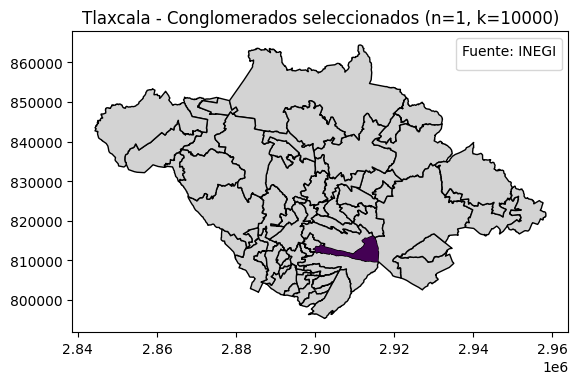

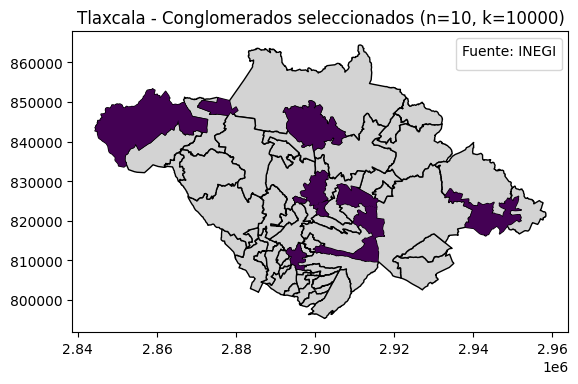

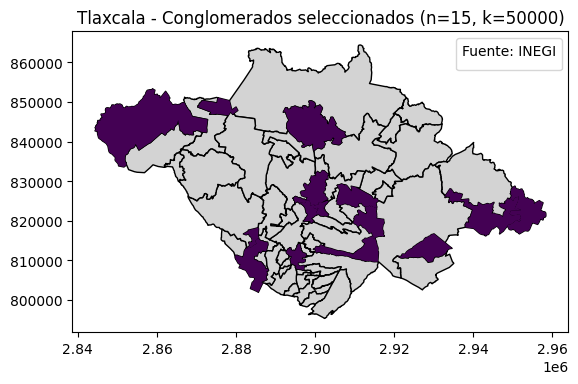

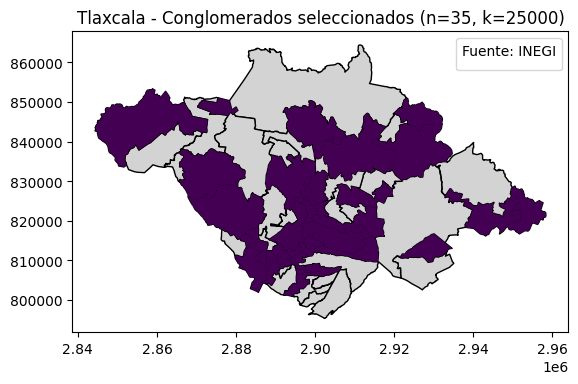

<ipython-input-4-7d735d178443>:106: RuntimeWarning: invalid value encountered in sqrt
  ee = np.sqrt(varianza_total)
<ipython-input-4-7d735d178443>:106: RuntimeWarning: invalid value encountered in sqrt
  ee = np.sqrt(varianza_total)
<ipython-input-4-7d735d178443>:106: RuntimeWarning: invalid value encountered in sqrt
  ee = np.sqrt(varianza_total)


In [4]:
# Filtrar el dataframe de municipios para obtener solo los de Tlaxcala
shapes_municipios_tlaxcala = shapes_municipios[shapes_municipios['CVE_ENT'] == '29']

# Definimos los valores para el número de cluster que seleccionaremos y el tamaño de muestra total que se seleccionará
# es decir, n y k.
valores_n = [1, 1,1,1,1,1,
             10,10,10,10, 10,10,
             15, 15, 15, 15, 15, 15,
             35, 35, 35, 35, 35, 35,
             50, 50, 50, 50, 50, 50,
             60, 60, 60, 60, 60, 60]
valores_k = [10000, 25000, 50000, 70000, 85000, 100000,
             10000, 25000, 50000, 70000, 85000, 100000,
             10000, 25000, 50000, 70000, 85000, 100000,
             10000, 25000, 50000, 70000, 85000, 100000,
             10000, 25000, 50000, 70000, 85000, 100000,
             10000, 25000, 50000, 70000, 85000, 100000]

# Creamos un DataFrame para almacenar los resultados
resultados = pd.DataFrame(columns=['n', 'k', 'limite_inferior', 'limite_superior'])

for n, k in zip(valores_n, valores_k):
    # Obtenemos los distintos Clusters
    clusters = viviendas_29['MUN'].unique()

    # Obtenemos el número total de clusters
    N = len(clusters)

    # Seleccionamos los 20 clusters de manera aleatoria
    random.seed(1234)
    sample_clusters = random.sample(list(clusters), n)

    # Asignamos el tamaño de muestra de manera proporcional para cada cluster

    tabla_aux1 = viviendas_29[viviendas_29['MUN'].isin(sample_clusters)].groupby(['ENT', 'MUN']).size().reset_index(name='Mi')
    tabla_aux1['mi'] = round(k * (tabla_aux1['Mi'] / tabla_aux1['Mi'].sum()))
    tabla_aux1['f1'] = N / n
    tabla_aux1['f2'] = tabla_aux1['Mi'] / tabla_aux1['mi']
    tabla_aux1['factor'] = tabla_aux1['f1'] * tabla_aux1['f2']
    tabla_aux1['unos'] = 1

    tabla_aux1 = tabla_aux1.sort_values(by='Mi', ascending=False)

    # De la tabla auxiliar extraemos los vectores que nos ayudarán a hacer la muestra para cada cluster

    vector_clusters = tabla_aux1['MUN'].tolist()
    vector_factores = tabla_aux1['factor'].tolist()
    vector_f1 = tabla_aux1['f1'].tolist()
    vector_f2 = tabla_aux1['f2'].tolist()
    vector_Mi = tabla_aux1['Mi'].tolist()
    vector_mi = tabla_aux1['mi'].tolist()

    # Iniciamos el proceso para crear la muestra

    muestra_por_conglomerados = pd.DataFrame()

    # Fijamos una semilla
    np.random.seed(2022)
    for i in range(len(vector_clusters)):
        muestra_i = viviendas_29[viviendas_29['MUN'] == vector_clusters[i]].sample(n=int(vector_mi[i]), replace=True)
        muestra_i['factor_total'] = vector_factores[i]
        muestra_i['f1'] = vector_f1[i]
        muestra_i['f2'] = vector_f2[i]
        muestra_i['Mi'] = vector_Mi[i]
        muestra_i['mi'] = vector_mi[i]

        # Hacemos un append a la tabla muestra
        muestra_por_conglomerados = pd.concat([muestra_por_conglomerados, muestra_i])

    muestra_por_conglomerados['NUMPERS']= muestra_por_conglomerados['NUMPERS'].astype(float)

    # Estadísticas descriptivas
    grouped_stats = muestra_por_conglomerados.groupby('MUN').agg({'NUMPERS': ['count', 'max'], 'TOTCUART': 'max'})
    grouped_stats.columns = ['n', 'max_pers', 'max_cuartos']

    # Estimación directa del total de personas
    estimacion_total_personas = (muestra_por_conglomerados['factor_total'] * muestra_por_conglomerados['NUMPERS']).sum()

    # Estimación para cada cluster
    estimacion_cluster = muestra_por_conglomerados.groupby('MUN')['f2', 'NUMPERS'].apply(lambda x: (x['f2'] * x['NUMPERS']).sum()).reset_index(name='total_personas')

    # Sumamos el total por cluster y multiplicamos por el factor de expansión de los clusters
    estimacion_total_cluster = estimacion_cluster['total_personas'].sum() * (N / n)

    # Calculamos la varianza de las estimaciones del total para los clusters
    s2b = estimacion_cluster['total_personas'].var()
    componente_s2b = (N**2) * (1 - n / N) * (s2b / n)

    # Calculamos la varianza de las estimaciones del total para los estratos
    tabla_aux_sw = muestra_por_conglomerados.groupby('MUN').agg({'NUMPERS': 'var', 'Mi': 'mean', 'mi': 'mean'}).reset_index()
    tabla_aux_sw['sumando'] = (tabla_aux_sw['Mi']**2) * (1 - tabla_aux_sw['mi'] / tabla_aux_sw['Mi']) * (tabla_aux_sw['NUMPERS'] / tabla_aux_sw['mi'])
    componente_s2wi = (N / n) * tabla_aux_sw['sumando'].sum()

    # Varianza total
    varianza_total = componente_s2b + componente_s2wi

    # Intervalo de confianza
    alpha = 0.10
    z = 1.645  # El valor crítico de la distribución normal estándar para un 90% de confianza
    ee = np.sqrt(varianza_total)

    # Calculamos el intervalo de confianza
    limite_inferior = estimacion_total_personas - z * ee
    limite_superior = estimacion_total_personas + z * ee

    # Añadimos los resultados a la tabla
    resultados = resultados.append({'n': n, 'k': k, 'limite_inferior': limite_inferior, 'limite_superior': limite_superior}, ignore_index=True)

    # Creamos un mapa para algunos valores de n y k
    if (n == 1 and k == 10000) or (n == 10 and k == 10000) or (n == 15 and k == 50000) or (n == 35 and k == 25000):
        fig, ax = plt.subplots()
        # Primera capa: todos los municipios en un color base
        shapes_municipios_tlaxcala.plot(ax=ax, color='lightgray', edgecolor='black')

        # Segunda capa: conglomerados seleccionados en un color diferente
        conglomerados_seleccionados = gpd.GeoDataFrame(shapes_municipios_tlaxcala).merge(tabla_aux1, left_on=['CVE_ENT', 'CVE_MUN'], right_on=['ENT', 'MUN'], how='left')
        conglomerados_seleccionados.plot(column='unos', ax=ax, legend=False, cmap='viridis')

        plt.title(f"Tlaxcala - Conglomerados seleccionados (n={n}, k={k})")
        plt.legend(title="Fuente: INEGI")

        # Mostramos los mapas
        plt.show()

## Resultados
____

In [5]:
resultados['Longitud del intervalo'] = resultados['limite_superior'] - resultados['limite_inferior']
resultados['¿El intervalo si contiene al parámetro?'] = (resultados['limite_inferior'] < estimacion_total_personas) & (estimacion_total_personas < resultados['limite_superior'])

In [6]:
resultados

,n,k,limite_inferior,limite_superior,Longitud del intervalo,¿El intervalo si contiene al parámetro?
0,1.0,10000.0,NaN,NaN,NaN,False
1,1.0,25000.0,NaN,NaN,NaN,False
2,1.0,50000.0,NaN,NaN,NaN,False
3,1.0,70000.0,NaN,NaN,NaN,False
4,1.0,85000.0,NaN,NaN,NaN,False
5,1.0,100000.0,NaN,NaN,NaN,False
6,10.0,10000.0,230037.645813,281409.802652,51372.156839,True
7,10.0,25000.0,231362.216265,282243.763399,50881.547134,True
8,10.0,50000.0,231471.317634,281949.365959,50478.048325,True
9,10.0,70000.0,231340.899501,282206.567211,50865.667709,True


## Comentarios
___

 ¿Es más favorable, aumentar el número de conglomerados y disminuir el número de muestra o disminuir el número de conglomerados y aumentar el tamaño de muestra?
## Aumentar el número de conglomerados y disminuir el tamaño de muestra:

### Ventajas:
1. **Mayor representatividad de los conglomerados:**
   - Un mayor número de conglomerados puede proporcionar una representación más completa de la variabilidad entre los conglomerados.
2. **Menos carga logística:**
   - Puede ser más fácil y menos costoso recolectar datos de un número menor de elementos dentro de cada conglomerado.

### Desventajas:
1. **Menor precisión en la estimación:**
   - Con un tamaño de muestra más pequeño, las estimaciones pueden ser menos precisas y tener mayores errores estándar.
2. **Menor poder estadístico:**
   - Puede haber una menor capacidad para detectar diferencias o patrones significativos en los datos.

## Disminuir el número de conglomerados y aumentar el tamaño de muestra:

### Ventajas:
1. **Mayor precisión en la estimación:**
   - Un mayor tamaño de muestra generalmente conduce a estimaciones más precisas y con errores estándar más pequeños.
2. **Mayor poder estadístico:**
   - Mayor capacidad para detectar diferencias o patrones en los datos.
  
### Desventajas:
1. **Menos representatividad de los conglomerados:**
   - Un menor número de conglomerados puede no capturar adecuadamente la variabilidad entre ellos.
2. **Mayores costos y carga logística:**
   - Recopilar datos de un mayor número de elementos puede ser más costoso y logísticamente más desafiante.

## Consideraciones adicionales:

1. **Diseño muestral:**
   - Dependiendo del diseño muestral específico, ciertos enfoques pueden ser más apropiados. Por ejemplo, en un diseño estratificado, puede ser más eficaz tener un número moderado de conglomerados en cada estrato.

 **Observaciones**

 - El intervalo de menor longitud que obtuvimos fue tomando $n=60$ y $n=50000$.